In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
from networkx import nx_agraph
import pygraphviz
from copy import deepcopy
sys.path.append("../src/")
sys.path.append("..")

In [54]:
from graph_functions import make_graphical_model
from sequential_causal_functions import powerset, sequentially_sample_model
from sequential_intervention_functions import (get_interventional_grids,make_sequential_intervention_dictionary)
from experiments import optimal_sequence_of_interventions, run_methods_replicates
from utilities import calculate_best_intervention_and_effect
from sem_estimate import make_sem_predator_prey_hat

Data from:
>Blasius B, Rudolf L, Weithoff G, Gaedke U, Fussmann G.F. Long-term cyclic persistence in an experimental predator-prey system. Nature (2019).

A series of ten chemostat experiments was performed, constituting a total of 1,948 measurement days (corresponding to 5.3 years of measurement) and covering 3 scenarios.

Constant environmental conditions (C1–C7, 1,428 measurement days). This scenario consisted of 4 trials with the alga M. minutum (C1–C4) which is what we use in these experiments. All data is lives in `data/plankton` and is freely available online.

## Create dataset

In [3]:
from utilities import create_plankton_dataset

In [4]:
observational_samples = create_plankton_dataset(start=0,end=3)

Units of all observation variables is (mu mol N / L).


In [5]:
observational_samples

{'M': array([[80., 80., 80.],
        [80., 80., 80.],
        [80., 80., 80.],
        [80., 80., 80.]]),
 'N': array([[42.  , 23.24, 19.6 ],
        [45.64, 22.4 , 17.92],
        [34.44, 17.64,  3.36],
        [43.12, 46.2 , 42.28]]),
 'P': array([[ 0.        ,  3.0894    , 10.4082    ],
        [ 0.342     ,  0.228     ,  5.8311    ],
        [ 4.2294    ,  4.44105497,  8.9205    ],
        [ 6.2928    ,  4.0014    ,  5.7171    ]]),
 'J': array([[0.        , 0.        , 5.265     ],
        [0.17142857, 0.114     , 2.92276596],
        [1.9       , 3.20952059, 4.47326087],
        [2.85      , 1.98336735, 2.8577027 ]]),
 'A': array([[ 0.        ,  0.        , 26.325     ],
        [ 0.85714286,  0.57      , 14.61382979],
        [ 9.5       , 16.04760296, 22.36630435],
        [14.25      ,  9.91683673, 14.28851351]]),
 'E': array([[0.        , 0.        , 4.0014    ],
        [0.456     , 0.228     , 2.7474    ],
        [0.114     , 4.84977451, 2.0577    ],
        [0.114     , 1

## Load SEM built from system ODE

In [6]:
from real_sems import PredatorPreySEM
SEM = PredatorPreySEM()
static_SEM = SEM.static()
dynamic_SEM = SEM.dynamic()

## Set autocorrelation noise ("red noise")

In [37]:
from numpy.random import seed
N = 4
seed(seed=0)
epsilon_list = []
mu = 0.
sigma=0.5
a=0.9
std = np.sqrt((sigma ** 2) * (1 - a ** 2))
T=3
s = T*[None]
for t in range(T):
    if t == 0:
        s[t] = a*np.random.randn() + np.random.normal(mu, std)
    else:
        s[t] = a*s[t-1] + np.random.normal(mu, std)

In [38]:
epsilon = {k: s for k in initial_structural_equation_model.keys()}

In [39]:
epsilon

{'M': [1.6748593530110014, 1.720684415955983, 2.0370073242897204],
 'N': [1.6748593530110014, 1.720684415955983, 2.0370073242897204],
 'P': [1.6748593530110014, 1.720684415955983, 2.0370073242897204],
 'J': [1.6748593530110014, 1.720684415955983, 2.0370073242897204],
 'A': [1.6748593530110014, 1.720684415955983, 2.0370073242897204],
 'E': [1.6748593530110014, 1.720684415955983, 2.0370073242897204],
 'D': [1.6748593530110014, 1.720684415955983, 2.0370073242897204]}

## Build corresponding causal graphical model

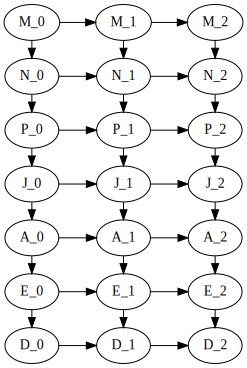

In [7]:
T = 3 # Simulation horizon
variables = ["M", "N", "P", "J", "A", "E", "D"]
graph_view = make_graphical_model(0,T-1,topology='dependent',nodes=variables,verbose=True) # Base topology
graph_view

We now add and remove edges to base topology above, to make it correspond to the dynamics of the original ODE dynamics.

In [8]:
# Convert DOT string to NetworkX object
Graph = nx_agraph.from_agraph(pygraphviz.AGraph(graph_view.source))

for t in range(T):
    # Remove some spatial connections according to original ODE
    Graph.remove_edge('J_{}'.format(t),'A_{}'.format(t))
    Graph.remove_edge('E_{}'.format(t),'D_{}'.format(t))
    # Add additional spatial connections
    Graph.add_edge('P_{}'.format(t),'A_{}'.format(t))
    Graph.add_edge('P_{}'.format(t),'E_{}'.format(t))
    Graph.add_edge('J_{}'.format(t),'D_{}'.format(t))
    Graph.add_edge('A_{}'.format(t),'D_{}'.format(t))

# Add horizontal connections
for t in range(T-1):
    # Remove connecting edge between instrument variables
    Graph.remove_edge('M_{}'.format(t),'M_{}'.format(t+1))
    Graph.add_edge('P_{}'.format(t),'N_{}'.format(t+1))
    Graph.add_edge('A_{}'.format(t),'J_{}'.format(t+1))

In [9]:
from real_sems import PredatorPreySEM
static_SEM = SEM.static()
dynamic_SEM = SEM.dynamic()
# Test sample CGM
noise_model = {k: np.zeros(T) for k in static_SEM.keys()}
sim_samples = sequentially_sample_model(static_SEM,
                                                  dynamic_SEM,
                                                  total_timesteps=T,
                                                  sample_count=1,
                                                  epsilon=noise_model)
sim_samples

{'M': array([[80., 80., 80.]]),
 'N': array([[35.88222688,  0.67866014, 42.00714841]]),
 'P': array([[ 8.00381583,  3.60040112, 10.77804495]]),
 'J': array([[1.63998426, 2.18598998, 0.51069055]]),
 'A': array([[ 8.19992132, 10.9299499 ,  2.55345277]]),
 'E': array([[2.35060014, 2.24453748, 1.05299093]]),
 'D': array([[ 1.47598584,  1.15559877, -0.17595783]])}

In [10]:
observational_samples

{'M': array([[80., 80., 80.],
        [80., 80., 80.],
        [80., 80., 80.],
        [80., 80., 80.]]),
 'N': array([[42.  , 23.24, 19.6 ],
        [45.64, 22.4 , 17.92],
        [34.44, 17.64,  3.36],
        [43.12, 46.2 , 42.28]]),
 'P': array([[ 0.        ,  3.0894    , 10.4082    ],
        [ 0.342     ,  0.228     ,  5.8311    ],
        [ 4.2294    ,  4.44105497,  8.9205    ],
        [ 6.2928    ,  4.0014    ,  5.7171    ]]),
 'J': array([[0.        , 0.        , 5.265     ],
        [0.17142857, 0.114     , 2.92276596],
        [1.9       , 3.20952059, 4.47326087],
        [2.85      , 1.98336735, 2.8577027 ]]),
 'A': array([[ 0.        ,  0.        , 26.325     ],
        [ 0.85714286,  0.57      , 14.61382979],
        [ 9.5       , 16.04760296, 22.36630435],
        [14.25      ,  9.91683673, 14.28851351]]),
 'E': array([[0.        , 0.        , 4.0014    ],
        [0.456     , 0.228     , 2.7474    ],
        [0.114     , 4.84977451, 2.0577    ],
        [0.114     , 1

# Find true causal effects

In [11]:
manipulative_variables = ['M','J','A']
exploration_sets = list(powerset(manipulative_variables))
intervention_domain = {'M':[40,160],'J':[0,20], "A":[0,100]} 
interventional_grids = get_interventional_grids(exploration_sets, intervention_domain, size_intervention_grid=100)

In [12]:
(best_intervention_values, best_intervention_sequence, best_objective_values, all_objective_values, optimal_interventions, all_causal_effects) = \
    optimal_sequence_of_interventions(exploration_sets, 
                                        interventional_grids, 
                                        static_SEM,
                                        dynamic_SEM,
                                        Graph,
                                        model_variables=static_SEM.keys(),
                                        target_variable='D',
                                        timesteps=T)

s ('M',)
s ('J',)
s ('A',)
s ('M', 'J')
 ../src/real_sems.py:55: RuntimeWarning:invalid value encountered in double_scalars
s ('M', 'A')
s ('J', 'A')
s ('M', 'J', 'A')
t == 0


t == 1


t == 2




In [14]:
for item in (best_intervention_values, best_intervention_sequence, best_objective_values, all_objective_values, optimal_interventions):
    print(item,"\n")

[array([0., 0.]), array([40.]), array([40.])] 

[('J', 'A'), ('M',), ('M',)] 

[0.0, 0.0, 0.0] 

{('M',): [1.1848254691156703, 0.0, 0.0], ('J',): [1.2299881980148444, 0.0, 0.0], ('A',): [0.24599763960296883, 0.0, 0.0], ('M', 'J'): [0.9873545575963919, 0.0, 0.0], ('M', 'A'): [0.19747091151927834, 0.0, 0.0], ('J', 'A'): [0.0, 0.0, 0.0], ('M', 'J', 'A'): [0.0, 0.0, 0.0]} 

{('M',): [array([40.]), array([40.]), array([40.])], ('J',): [array([0.]), array([0.]), array([0.])], ('A',): [array([0.]), array([0.]), array([0.])], ('M', 'J'): [array([40.,  0.]), array([40.,  0.]), array([40.,  0.])], ('M', 'A'): [array([40.,  0.]), array([40.,  0.]), array([40.,  0.])], ('J', 'A'): [array([0., 0.]), array([0., 0.]), array([0., 0.])], ('M', 'J', 'A'): [array([40.,  0.,  0.]), array([40.,  0.,  0.]), array([40.,  0.,  0.])]} 



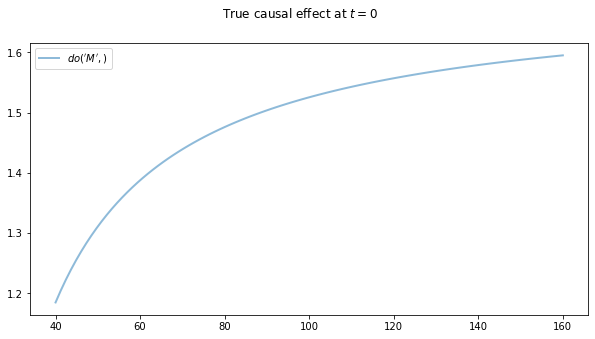

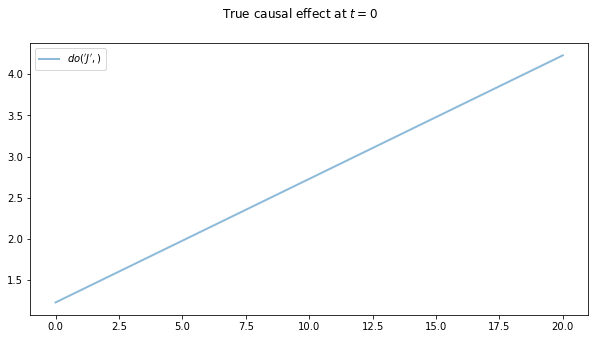

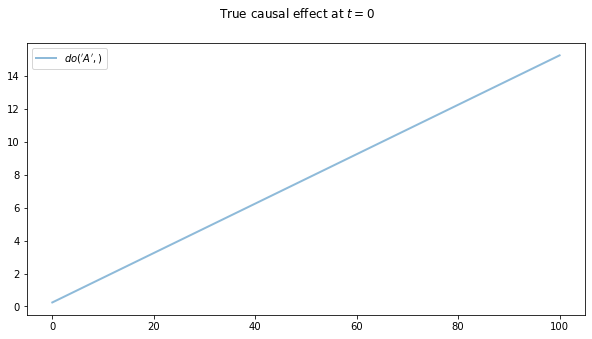

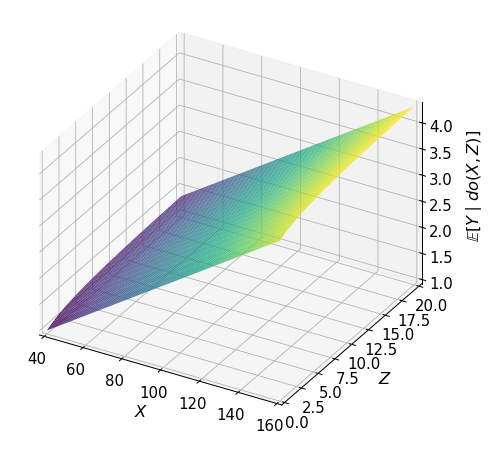

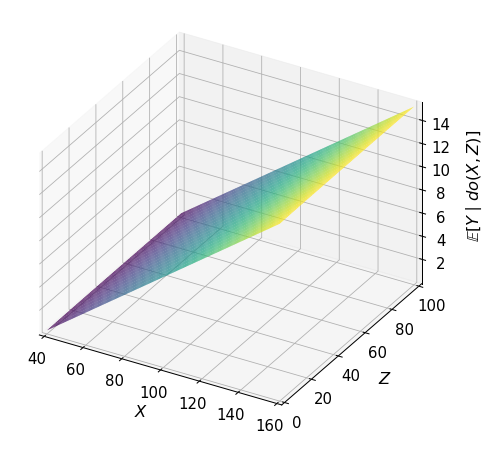

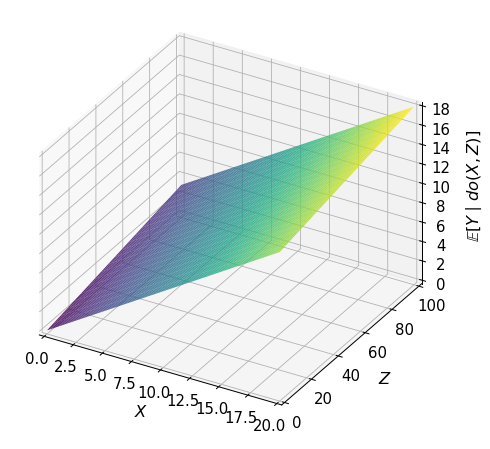

 ../src/real_sems.py:55: RuntimeWarning:invalid value encountered in double_scalars


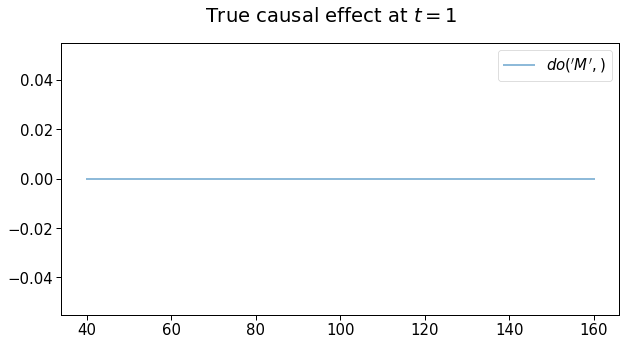

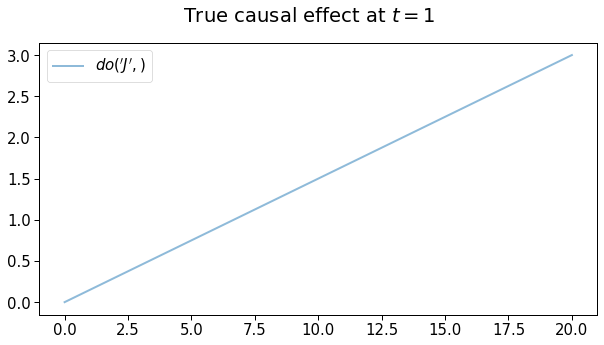

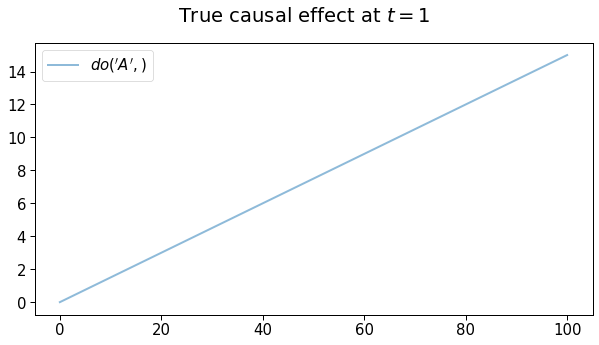

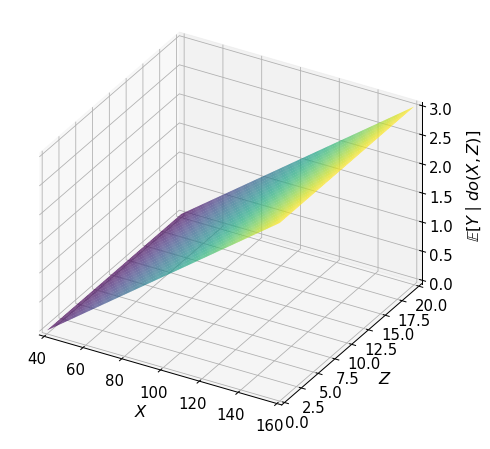

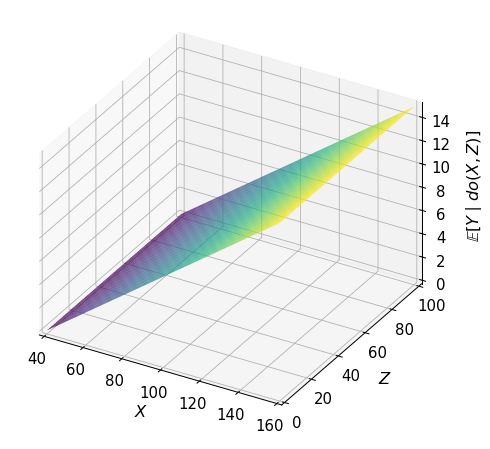

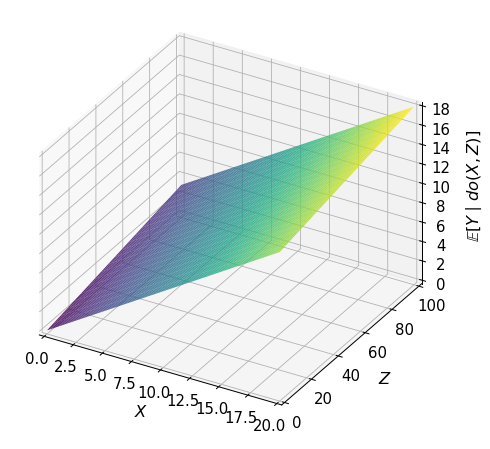

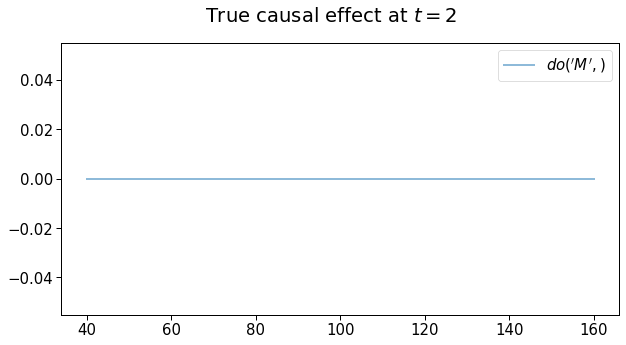

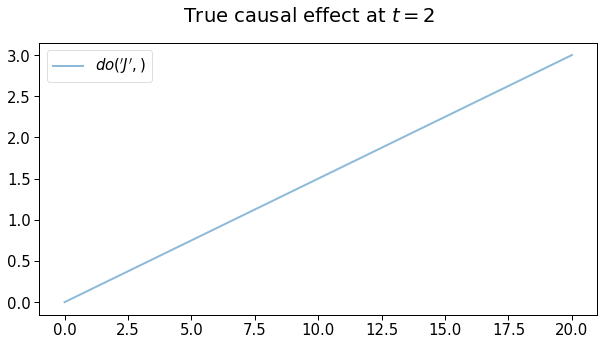

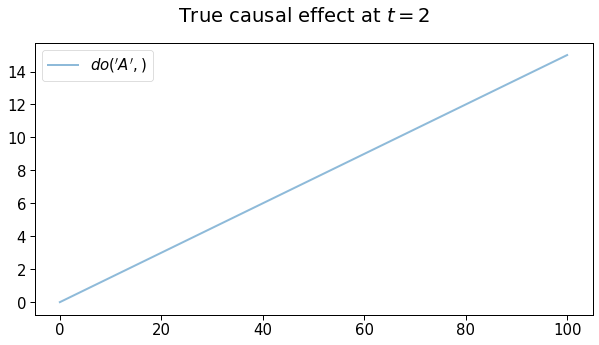

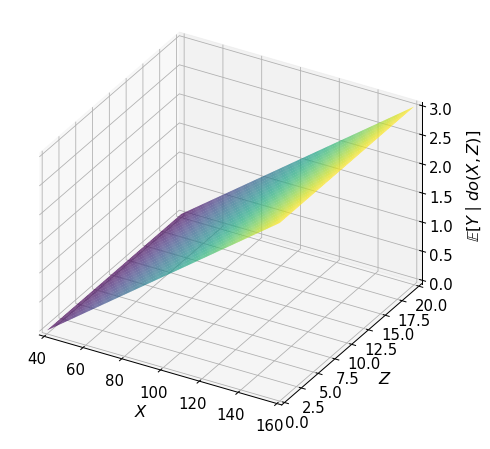

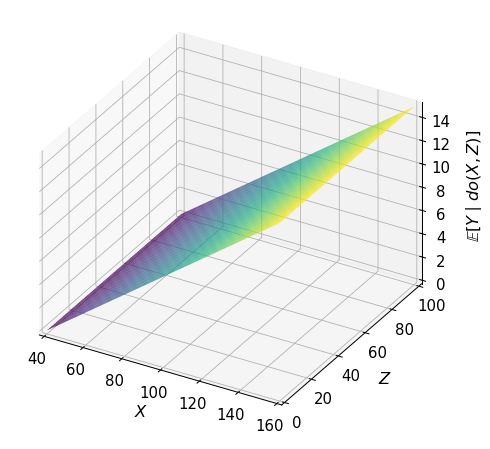

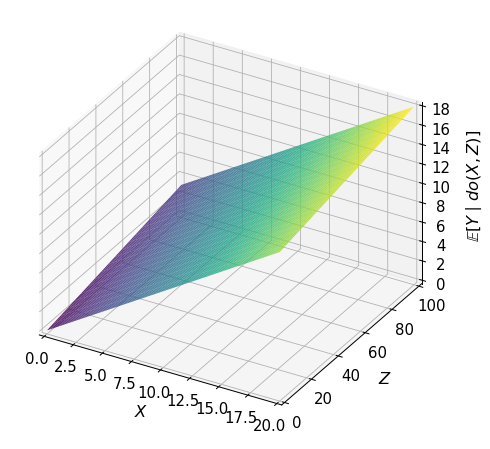

In [13]:
GT = []
optimal_assigned_blankets = [None]*T

blanket, _ = make_sequential_intervention_dictionary(Graph)
for t in range(T):
    new_blanket, true_causal_effect  = calculate_best_intervention_and_effect(
                                          static_sem=static_SEM,
                                          dynamic_sem=dynamic_SEM,
                                          exploration_sets=exploration_sets,
                                          interventional_grids=interventional_grids,
                                          time=t,
                                          intervention_domain=intervention_domain,
                                          blanket=deepcopy(blanket),
                                          target='D',
                                          T=T,
                                          plot = True)
    if t < T-1: 
        optimal_assigned_blankets[t+1] = new_blanket
    
    blanket = new_blanket
    
    GT.append(true_causal_effect)

In [19]:
optimal_assigned_blankets

[None,
 {'A': [0.0, None, None],
  'D': [0.0, None, None],
  'E': [None, None, None],
  'J': [0.0, None, None],
  'M': [None, None, None],
  'N': [None, None, None],
  'P': [None, None, None]},
 {'A': [0.0, None, None],
  'D': [0.0, 0.0, None],
  'E': [None, None, None],
  'J': [0.0, None, None],
  'M': [None, 40.0, None],
  'N': [None, None, None],
  'P': [None, None, None]}]

In [14]:
from sem_estimate import auto_sem_dependent_stationary_hat

In [21]:
### TODO: currently not clear what do with the conditional distribution for the instrument variable if there is only one measured value for the instrument

# Check that order of nodes is maintained
assert [v.split("_")[0] for v in [v for v in Graph.nodes if v.split("_")[1] == "0"]] == variables



In [443]:
dcbo.sem_trans_fncs

{('N_0', 'P_0'): <GPy.models.gp_regression.GPRegression at 0x7fa8e1cc1ad0>,
 ('P_0',): <GPy.models.gp_regression.GPRegression at 0x7fa8e1c90a90>,
 ('J_0', 'A_0'): <GPy.models.gp_regression.GPRegression at 0x7fa93381d090>,
 ('A_0',): <GPy.models.gp_regression.GPRegression at 0x7fa93384e190>,
 ('E_0',): <GPy.models.gp_regression.GPRegression at 0x7fa93383f650>,
 ('D_0',): <GPy.models.gp_regression.GPRegression at 0x7fa93381da90>,
 ('N_1', 'P_1'): <GPy.models.gp_regression.GPRegression at 0x7fa933829790>,
 ('P_1',): <GPy.models.gp_regression.GPRegression at 0x7fa94121fa50>,
 ('J_1', 'A_1'): <GPy.models.gp_regression.GPRegression at 0x7fa94122cb50>,
 ('A_1',): <GPy.models.gp_regression.GPRegression at 0x7fa94121f2d0>,
 ('E_1',): <GPy.models.gp_regression.GPRegression at 0x7fa941226550>,
 ('D_1',): <GPy.models.gp_regression.GPRegression at 0x7fa9338438d0>}

In [463]:
new_sem_hat = auto_sem_dependent_stationary_hat(variables,True,dcbo.sem_emit_fncs, dcbo.sem_trans_fncs)

In [464]:
static_sem = new_sem_hat().static(moment=0)  # for t = 0
sem = new_sem_hat().dynamic(moment=0)  # for t > 0

In [474]:
dcbo.node_parents

{'M_0': (),
 'N_0': ('M_0',),
 'P_0': ('N_0',),
 'J_0': ('P_0',),
 'A_0': ('P_0',),
 'E_0': ('A_0', 'P_0'),
 'D_0': ('J_0', 'A_0'),
 'M_1': (),
 'N_1': ('N_0', 'M_1', 'P_0'),
 'P_1': ('P_0', 'N_1'),
 'J_1': ('J_0', 'P_1', 'A_0'),
 'A_1': ('A_0', 'P_1'),
 'E_1': ('E_0', 'A_1', 'P_1'),
 'D_1': ('D_0', 'J_1', 'A_1'),
 'M_2': (),
 'N_2': ('N_1', 'M_2', 'P_1'),
 'P_2': ('P_1', 'N_2'),
 'J_2': ('J_1', 'P_2', 'A_1'),
 'A_2': ('A_1', 'P_2'),
 'E_2': ('E_1', 'A_2', 'P_2'),
 'D_2': ('D_1', 'J_2', 'A_2')}

In [475]:
from numpy.random import randn
f = lambda: randn()

In [27]:
from dcbo import DCBO
change_points = T*[False]
DCBO_input_params = {
    "graph": Graph,
    "sem": PredatorPreySEM,
    "make_sem_hat": auto_sem_dependent_stationary_hat,#make_sem_predator_prey_hat,
    "observational_samples": observational_samples,
    "intervention_domain": intervention_domain,
    "interventional_samples": None,  
    "exploration_sets": exploration_sets,# [exploration_sets[5]],
    "number_of_trials": 3,
    "ground_truth": GT,
    "debug_mode": False,
    "base_target_variable":'D',
    "optimal_assigned_blankets": None,#optimal_assigned_blankets,
    "transfer_hp_i": False,
    "transfer_hp_o": False,
    "use_di": False,
    "n_obs_t": None,
    "num_anchor_points": 100,
    "sample_anchor_points": True,
    "seed_anchor_points": 1,
    "change_points": change_points,
    "manipulative_variables": manipulative_variables,
    "root_instrument":True
}

In [28]:
dcbo = DCBO(**DCBO_input_params)

In [29]:
dcbo.run_optimization()

Time index:  33%|███▎      | 1/3 [00:02<00:04,  2.30s/it]Optimization restart 1/1, f = 5.300353950454271
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
Time index:  67%|██████▋   | 2/3 [00:07<00:04,  4.22s/it]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
Time index: 100%|██████████| 3/3 [00:15<00:00,  5.30s/it]


In [22]:
y_stars = [min([min(all_causal_effects[t][es]) for es in exploration_sets]) for t in range(T)]

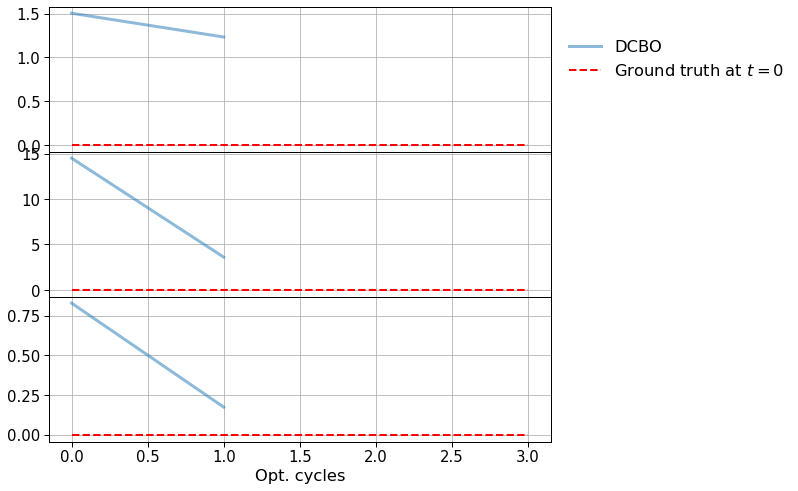

In [30]:
fig, ax = plt.subplots(T, figsize=(9,8), sharex=True)
for i in range(T):
    ax[i].plot(dcbo.optimal_outcome_values_during_trials[i][1:],lw=3,label='DCBO',alpha=0.5)
    ax[i].hlines(y_stars[i],0,DCBO_input_params["number_of_trials"],
                 'r',ls='--',lw=2,alpha=1,label='Ground truth at $t={}$'.format(i))
    ax[i].grid(True)
    if i ==0:
        ax[i].legend(ncol=1, fontsize="medium", loc="lower center", frameon=False, bbox_to_anchor=(1.25, 0.4))

ax[2].set_xlabel(r"Opt. cycles")

plt.subplots_adjust(hspace=0)
plt.show()

# CBO

In [38]:
from cbo import CBO
change_points = T*[False]
CBO_input_params = {
    "graph": Graph,
    "sem": PredatorPreySEM,
    "make_sem_hat": auto_sem_dependent_stationary_hat,
    "observational_samples": observational_samples,
    "intervention_domain": intervention_domain,
    "exploration_sets": exploration_sets,
    "interventional_samples": None,   
    "number_of_trials": 2, 
    "ground_truth": GT,
    "base_target_variable":'D', 
    "debug_mode": False,
    "optimal_assigned_blankets": None, #optimal_assigned_blankets,
    "n_obs_t": None,
    "num_anchor_points": 100,
    "sample_anchor_points": True,
    "seed_anchor_points": 1,
    "change_points" : change_points,
    "manipulative_variables": manipulative_variables,
    "root_instrument":True
}

In [39]:
cbo = CBO(**CBO_input_params)
cbo.run_optimization()

Time index:   0%|          | 0/3 [00:00<?, ?it/s] ../src/real_sems.py:55: RuntimeWarning:invalid value encountered in double_scalars
reconstraining parameters GP_regression.rbf.variance
Time index: 100%|██████████| 3/3 [00:06<00:00,  2.09s/it]


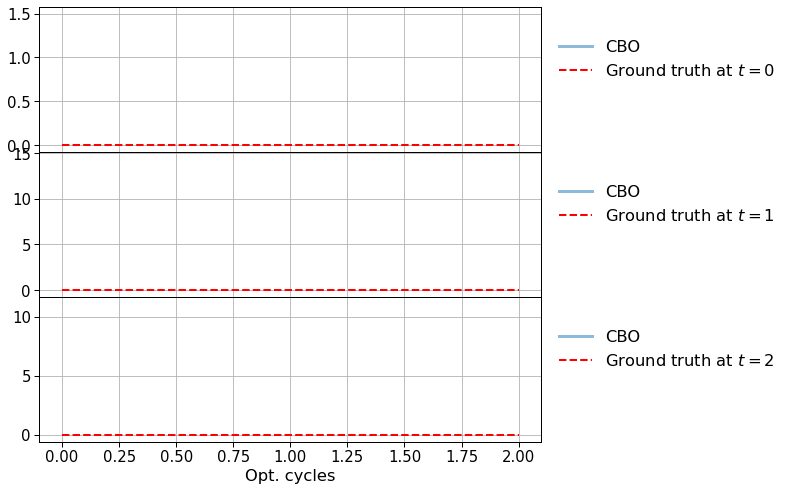

In [40]:
fig, ax = plt.subplots(T, figsize=(9,8), sharex=True)
for i in range(T):
    ax[i].plot(cbo.optimal_outcome_values_during_trials[i][1:],lw=3,label='CBO',alpha=0.5)
    ax[i].hlines(y_stars[i],0,CBO_input_params["number_of_trials"],
    'r',ls='--',lw=2,alpha=1,label='Ground truth at $t={}$'.format(i))
    ax[i].grid(True)
    ax[i].legend(ncol=1, fontsize="medium", loc="lower center", frameon=False, bbox_to_anchor=(1.25, 0.4))

ax[2].set_xlabel(r"Opt. cycles")

plt.subplots_adjust(hspace=0)
plt.show()

# ABO

In [41]:
from abo import ABO
ABO_input_params = {
    "graph": Graph,
    "sem": PredatorPreySEM,
    "observational_samples": observational_samples,
    "intervention_domain":intervention_domain,
    "interventional_samples": None,   
    "number_of_trials": 10,
    "optimal_assigned_blankets": None, #optimal_assigned_blankets,
    "sample_anchor_points": True,
    "base_target_variable":'D',
    "seed_anchor_points": 1,
    "change_points": change_points,
    "manipulative_variables": manipulative_variables
}

In [42]:
abo = ABO(**ABO_input_params)
abo.run_optimization()

Time index:  33%|███▎      | 1/3 [00:00<00:00,  6.96it/s]reconstraining parameters GP_regression.rbf.variance
Optimization restart 1/1, f = 24.8323610459949
Optimization restart 1/1, f = 29.29910357302344
Optimization restart 1/1, f = 32.19589722932481
Optimization restart 1/1, f = 36.368302791828945
Optimization restart 1/1, f = 40.61988098271257
Optimization restart 1/1, f = 43.240314675223615
Optimization restart 1/1, f = 48.15382942441446
Optimization restart 1/1, f = 55.455639250962875
Optimization restart 1/1, f = 58.73396682547678
Optimization restart 1/1, f = 62.68492668462693
Optimization restart 1/1, f = 65.35035268184375
Optimization restart 1/1, f = 70.51409584000497
Optimization restart 1/1, f = 73.34324676973837
Optimization restart 1/1, f = 76.86082615780936
Optimization restart 1/1, f = 79.65643177061769
Time index: 100%|██████████| 3/3 [00:00<00:00,  6.39it/s]
Optimization restart 1/1, f = 85.79610744166496
Optimization restart 1/1, f = 90.50538555097818
Optimization r

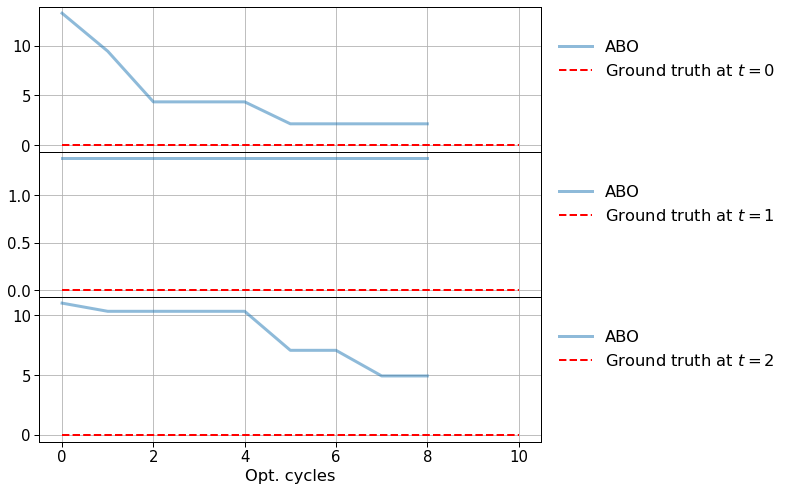

In [43]:
fig, ax = plt.subplots(T, figsize=(9,8), sharex=True)
for i in range(T):
    ax[i].plot(abo.optimal_outcome_values_during_trials[i][1:],lw=3,label='ABO',alpha=0.5)
    ax[i].hlines(y_stars[i],0,ABO_input_params['number_of_trials'],
    'r',ls='--',lw=2,alpha=1,label='Ground truth at $t={}$'.format(i))
    ax[i].grid(True)
    ax[i].legend(ncol=1, fontsize="medium", loc="lower center", frameon=False, bbox_to_anchor=(1.25, 0.4))

ax[2].set_xlabel(r"Opt. cycles")

plt.subplots_adjust(hspace=0)
plt.show()

# BO

In [47]:
from bo import BO
BO_input_params = {
    "graph": Graph,
    "sem": PredatorPreySEM,
    "observational_samples": observational_samples,
    "intervention_domain": intervention_domain,
    "interventional_samples":None,   
    "number_of_trials": 30,
    "base_target_variable":'D',
    "optimal_assigned_blankets": None, #optimal_assigned_blankets,
    "sample_anchor_points": True,
    "seed_anchor_points": 1,
    "change_points": change_points,
    "manipulative_variables": manipulative_variables
}

In [48]:
bo = BO(**BO_input_params)
bo.run_optimization()

Time index:   0%|          | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance
Time: 0
Optimization restart 1/1, f = 24.8323610459949
Optimization restart 1/1, f = 29.29910357302344
Optimization restart 1/1, f = 32.19589722932481
Optimization restart 1/1, f = 36.368302791828945
Optimization restart 1/1, f = 40.61988098271257
Optimization restart 1/1, f = 43.240314675223615
Optimization restart 1/1, f = 48.15382942441446
Optimization restart 1/1, f = 55.455639250962875
Optimization restart 1/1, f = 58.73396682547678
Optimization restart 1/1, f = 63.04579017269076
Optimization restart 1/1, f = 68.53723289093466
Optimization restart 1/1, f = 73.43619511146278
Optimization restart 1/1, f = 78.99971735741414
Optimization restart 1/1, f = 84.87500293549346
Time index:  33%|███▎      | 1/3 [00:00<00:00,  2.67it/s]reconstraining parameters GP_regression.rbf.variance
Optimization restart 1/1, f = 91.50303421540866
Optimization restart 1/1, f = 94.43752368410351
Optimizati

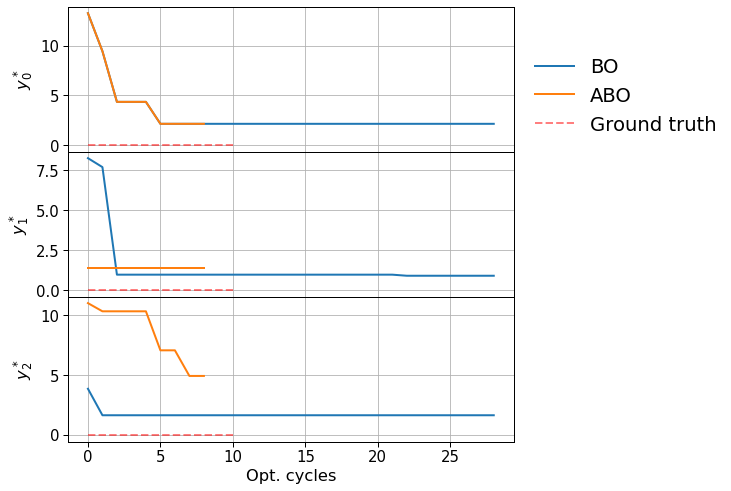

In [49]:
fig, ax = plt.subplots(T, figsize=(8,8), sharex=True)
for i in range(T):
    ax[i].plot(bo.optimal_outcome_values_during_trials[i][1:],lw=2,label='BO')
    ax[i].plot(abo.optimal_outcome_values_during_trials[i][1:],lw=2,label='ABO')
    ax[i].hlines(best_objective_values[i],0,10,'r',ls='--',lw=2,alpha=0.5,label='Ground truth')
    ax[i].set_ylabel(r"$y^*_{}$".format(i))
    ax[i].grid(True)
    if i == 0:
        ax[i].legend(ncol=1, fontsize="large", loc="lower center", frameon=False, bbox_to_anchor=(1.25, 0.))
ax[2].set_xlabel(r"Opt. cycles")

plt.subplots_adjust(hspace=0)
plt.show()

In [55]:
%%time
n_replicates = 10
n_trials = 20
number_of_interventions = None
folder = 'plankton'
online = False
concat = False
n_obs = 4
sample_anchor_points = True
cost_list = [1]
n_obs_t = None,
noise_experiment = False
for cost in cost_list:
    results = run_methods_replicates(graph=Graph, 
                                     sem=PredatorPreySEM, 
                                     make_sem_hat = auto_sem_dependent_stationary_hat,
                                     root_instrument = True,
                                     intervention_domain = intervention_domain, 
                                     methods_list = ['DCBO', 'CBO', 'ABO', 'BO'],
                                     obs_samples = observational_samples,
                                     exploration_sets = exploration_sets,
                                     manipulative_variables =  manipulative_variables,
                                     base_target_variable = 'D',
                                     ground_truth = GT,
                                     total_timesteps = T,
                                     reps = n_replicates,
                                     number_of_trials = n_trials, 
                                     n_restart = 1,
                                     save_data = True,
                                     n_obs = n_obs,
                                     online = False,
                                     concat = False,
                                     use_di = False, 
                                     transfer_hp_i = False,
                                     transfer_hp_o = False,
                                     hp_i_prior = True,
                                     debug_mode = False,
                                     folder = folder,
                                     optimal_assigned_blankets = None, #optimal_assigned_blankets,
                                     num_anchor_points = 100,
                                     n_obs_t = n_obs_t,
                                     sample_anchor_points = sample_anchor_points,
                                     controlled_experiment=True,
                                     noise_experiment=noise_experiment,
                                     change_points=change_points)

Experiment count:   0%|          | 0/10 [00:00<?, ?it/s]
	>>>DCBO

 /Users/nd/anaconda3/envs/scibo/lib/python3.7/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square

Time index:   0%|          | 0/3 [00:00<?, ?it/s] ../src/real_sems.py:55: RuntimeWarning:invalid value encountered in double_scalars
reconstraining parameters GP_regression.rbf.variance
Optimization restart 1/1, f = 5.300353950454271
Optimization restart 1/1, f = 7.149417384939059
Optimization restart 1/1, f = 9.036502466029624
Optimization restart 1/1, f = 10.812010811016217
Optimization restart 1/1, f = 12.66990279333216
Optimization restart 1/1, f = 14.543187452987144
Optimization restart 1/1, f = 16.42337274984274
Optimization restart 1/1, f = 18.161475397249
Optimization restart 1/1, f = 19.966616650288902
Optimization restart 1/1, f = 21.832897860907217
Optimization restart 1/1, f = 23.671899222117617
Optimization restart 1/1, f = 25.378067175041355
Optimization restart 1/1, f = 27.196

In [ ]:
dcbo

# Results

In [403]:
import pickle
from analyse_results import (elaborate, get_common_initial_values, gap_metric_standard, 
                            get_table_values, get_average_performance_t, get_converge_trial,
                             count_optimal_intervention_set, compute_gap, plot_expected_opt_curve_paper)
import seaborn as sns


In [396]:
number_of_interventions = None
n_replicates = 10
n_trials = 20
T = 3
cost = 1
best_objective_values = [0.0, 0.0, 0.0]
optimal_set = [('J', 'A'), ('M',), ('M',)]
pickle_off = open("../data/plankton/method_DCBOCBOABOBO_T_3_it_20_reps_10_Nobs_4_online_False_concat_False_transfer_False_usedi_False_hpiprior_True_missing_False_noise_False_optimal_assigned_blanket_True.pickle","rb")
data = pickle.load(pickle_off)

In [398]:
exp_optimal_outcome_values_during_trials, exp_per_trial_cost = elaborate(number_of_interventions, 
                                                                         n_replicates, n_trials, 
                                                                         data, best_objective_values, T)

In [404]:
plot_params = {
    "linewidth": 3,
    "linewidth_opt": 4,
    "alpha": 0.1,
    "xlim_max": 120,
    "ncols": 5,
    "loc_legend": "lower right",
    "size_ticks": 20,
    "size_labels": 20,
    "xlabel": r'$\textrm{cost}(X_{s,t}, x_{s,t})$',

    "labels": {'DCBO': 'DCBO', 'CBO': 'CBO', 'ABO': 'ABO', 'BO': 'BO', 'True': '$\mathbb{E}[Y_t| do(X_{st}^\star = x_{st}^\star)$'},
    "colors": {'DCBO': 'blue', 'CBO': 'green', 'ABO': 'orange', 'BO': 'black', 'True': 'red'},
    "line_styles": {'DCBO': '-', 'CBO': '--', 'ABO': 'dashdot', 'BO': '-', 'True': '-'},
}


plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amssymb}')
plt.rc('font', family='serif')
plt.rc('font', size=20)

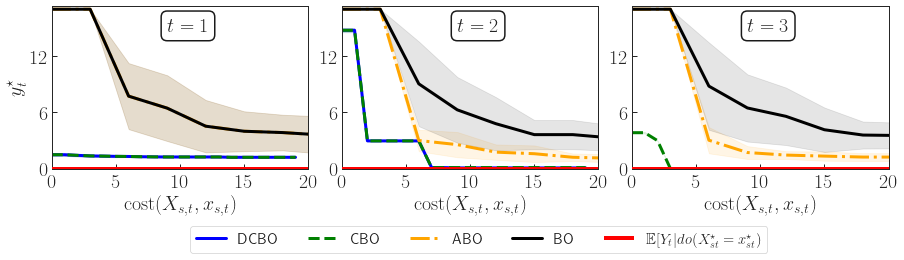

In [405]:
# Plot
plot_params['xlim_max'] = n_trials
plot_expected_opt_curve_paper(T,
    best_objective_values,
    exp_per_trial_cost,
    exp_optimal_outcome_values_during_trials,
    plot_params,  
    fig_size = (15,3))

In [406]:
where_converge_dict = get_converge_trial(best_objective_values, 
                                         exp_optimal_outcome_values_during_trials, 
                                         n_trials, 
                                         T, 
                                         n_decimal=2)
count_optimal_set = count_optimal_intervention_set(n_replicates, T, data, optimal_set)
print('where_converge_dict\n', where_converge_dict)
print('count_optimal_set\n', count_optimal_set)

where_converge_dict
 {'DCBO': [20, 20, 0], 'CBO': [20, 20, 3], 'ABO': [20, 20, 20], 'BO': [20, 20, 20]}
count_optimal_set
 {'DCBO': [0.0, 0.0, 10.0], 'CBO': [0.0, 0.0, 10.0], 'ABO': [0.0, 0.0, 0.0], 'BO': [0.0, 0.0, 0.0]}


In [407]:
(dict_gap, dict_gap_summary, 
dict_gap_iters_summary, 
dict_gap_iters_set_summary) = compute_gap(T, data, best_objective_values, 
                                           n_replicates, n_trials,where_converge_dict, 
                                          count_optimal_set, use_initial_value=False)
total_list_mean = get_table_values(dict_gap_iters_set_summary, T, n_decimal_mean = 4, n_decimal_std = 4)

 ../src/analyse_results.py:46: RuntimeWarning:divide by zero encountered in double_scalars
 ../src/analyse_results.py:46: RuntimeWarning:invalid value encountered in double_scalars
 ../src/analyse_results.py:62: RuntimeWarning:divide by zero encountered in long_scalars
 ../src/analyse_results.py:63: RuntimeWarning:invalid value encountered in multiply


In [408]:
total_initial_list = get_common_initial_values(T, data, best_objective_values, 
                                               n_replicates, where_converge_dict, count_optimal_set)
standardized_gap = gap_metric_standard(T, 
                                       data, 
                                       best_objective_values, 
                                       total_initial_list,
                    n_replicates, n_trials, where_converge_dict)
total_list_mean = get_table_values(standardized_gap, T, n_decimal_mean = 3, n_decimal_std = 3)
average_metrics = get_average_performance_t(data, standardized_gap, T)
average_metrics_tables = get_table_values(average_metrics, 1, n_decimal_mean = 3, n_decimal_std = 3)

In [409]:
average_metrics_tables

[['DCBO', 0.671],
 [' ', '(0.001)'],
 ['CBO', 0.645],
 [' ', '(0.001)'],
 ['ABO', 0.476],
 [' ', '(0.013)'],
 ['BO', 0.44],
 [' ', '(0.025)']]